## 矢量计算与标量计算的时间比较

In [1]:
%matplotlib inline
import torch
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random

## 线性回归的从零开始实现

### 生成数据集
设训练数据集样本数为1000，输入个数（特征数）为2， 给定随机生成的批量样本特征$X\in\mathbb{R}^{1000\times2}$  
使用线性回归模型真实权重$w=[2, -3.4]^{T}$和偏差$b=4.2$，以及一个随机噪声项$\epsilon$来生成标签：  
$$y = Xw + b + \epsilon$$

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2

features = torch.from_numpy(np.random.normal(0, 1, (num_examples, num_inputs)))
labels = true_w[0] * features[:,0] + true_w[1] * features[:, 1] + true_b
labels += torch.from_numpy(np.random.normal(0, 0.01, size=labels.size()))

In [3]:
features[0], labels[0]

(tensor([ 0.1212, -0.9569], dtype=torch.float64),
 tensor(7.6910, dtype=torch.float64))

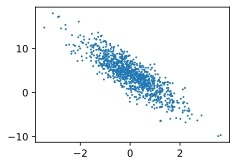

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
    
    
def set_figsize(figsize = (3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# from d2lzh_pytorch import *

set_figsize()

plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);  # 加分号只显示图

将上述两个功能函数放在dzlzh_pytorch包里。

### 读取数据

In [5]:
# 小批量随机读取数据样本
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 打乱索引顺序
    random.shuffle(indices)
    
    for i in range(0, num_examples, batch_size):
        # 选取每批样本，注意最后一次可能不足一个batch
        j = torch.LongTensor(indices[i : min(i+batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [6]:
batch_size = 10

for x, y in data_iter(batch_size, features, labels):
    print(x, y)
    break

tensor([[ 1.4440,  0.1096],
        [-0.7308,  1.0087],
        [ 0.4736,  1.2019],
        [-0.6316, -0.1630],
        [-0.6219,  1.1147],
        [ 0.7036, -2.5841],
        [-0.6081,  0.5061],
        [-0.7293,  0.8670],
        [ 1.2205, -0.3654],
        [ 0.4226, -0.3053]], dtype=torch.float64) tensor([ 6.7156, -0.6865,  1.0809,  3.4967, -0.8296, 14.4018,  1.2625, -0.2022,
         7.8761,  6.0870], dtype=torch.float64)


### 初始化模型参数

In [7]:
# 权重初始化为均值是0、标准差为0.01的正态随机数， 偏差初始化为0
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float64)
b = torch.zeros(1, dtype=torch.float64)

模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让他们的requires_grad=True

In [8]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], dtype=torch.float64, requires_grad=True)

### 定义模型

In [9]:
def linreg(X, w, b):
    # 使用 mm 函数做矩阵乘法
    return torch.mm(X, w) + b

### 定义损失函数

用平方损失来定义线性回归的损失函数，实现时，需要将真实值y变形成预测值y_hat的形状

In [10]:
def squared_loss(y_hat, y):
    # 返回的是向量，pytorch里的MSELoss没有除以2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

### 定义优化算法
sgd实现了小批量随机梯度下降算法，它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是⼀个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [11]:
# 小批量随机梯度下降算法
# lr 学习率
def sgd(params, lr, batch_size):
    for param in params:
        # 注意这里更改param时用的是param.data
        param.data -= lr * param.grad / batch_size

### 训练模型

In [16]:
lr = 0.03   # 学习率
num_epochs = 5
net = linreg
loss = squared_loss

# 训练模型一共需要num_epochs个周期
for epoch in range(num_epochs):
    # 每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）
    # x和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        # l是有关小批量X和y的损失
        l = loss(net(X, w, b), y).sum()
        # 小批量的损失对模型参数求梯度
        l.backward()
        # 使用小批量随机梯度下降迭代模型参数
        sgd([w, b], lr, batch_size)
    
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
        
    train_1 = loss(net(features, w, b), labels)
    print("epoch %d， loss %f" % (epoch + 1, train_1.mean().item()))

epoch 1， loss 0.000056
epoch 2， loss 0.000056
epoch 3， loss 0.000056
epoch 4， loss 0.000056
epoch 5， loss 0.000056


In [15]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0001],
        [-3.3996]], dtype=torch.float64, requires_grad=True)
4.2 
 tensor([4.1997], dtype=torch.float64, requires_grad=True)


## 简单实现

In [2]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

### 读取数据
使用pytorch提供的data包读取数据

In [3]:
import torch.utils.data as Data

batch_size = 10
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features, labels)
# 随机读取小批量
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

In [4]:
for X, y in data_iter:
    print(X, y)
    break

tensor([[-0.6460, -1.3332],
        [-1.4568,  1.5410],
        [ 0.4403, -2.5288],
        [ 0.7882, -1.3327],
        [-1.7759,  0.1443],
        [ 0.1659,  0.8179],
        [-0.1692,  0.6042],
        [ 0.0449, -0.6940],
        [-1.2618,  0.3059],
        [-0.8537,  0.9345]]) tensor([ 7.4330, -3.9527, 13.6891, 10.3085,  0.1379,  1.7525,  1.8157,  6.6481,
         0.6429, -0.6854])


### 定义模型
pytorch提供了大量预定义的层。
导入torch.nn模块，该模块定义了大量神经网络的层，nn的核心数据

In [7]:
import torch.nn as nn

class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
        
    # forward 定义前向传播
    def forward(self, x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)
print(net)
        

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


也可以用nn.Sequential来方便地搭建网络，Sequential是一个有序的容器，网络层将按照在传入Sequential的顺序依次被添加到计算图中。

In [8]:
# 写法一
net = nn.Sequential(
    nn.Linear(num_inputs, 1)
    # 此处可传入其它层
)

# 写法二
net = nn.Sequential()
net.add_module('linear', nn.Linear(num_inputs, 1))
# net.add_module ....

# 写法三
from collections import OrderedDict
net = nn.Sequential(OrderedDict([
    ('linear', nn.Linear(num_inputs, 1))
    # 添加其它层
]))

print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [9]:
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[ 0.3645, -0.5767]], requires_grad=True)
Parameter containing:
tensor([-0.3989], requires_grad=True)


### 初始化模型参数
PyTorch的init模块

In [11]:
from torch.nn import init

init.normal_(net[0].weight, mean=0, std=0.01)
init.constant_(net[0].bias, val=0)
# 也可以直接修改bias的data
# net[0].bias.data.fill_(0)

tensor([0.])

### 定义损失函数
nn的模块中提供了各种损失函数，这些损失函数可以看做是一种特殊的层。

In [12]:
loss = nn.MSELoss()   # 均方误差损失函数

### 定义优化算法
torch.optim模块提供了很多常用的优化算法

In [13]:
import torch.optim as optim

# 指定学习率为0.03的小批量随机梯度下降（SGD）为优化算法
optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


为不同的网络设置不同的学习率，这在finetune时经常用到

In [ ]:
optimizer = optim.SGD([
    # 如果对某个参数不指定学习率，就使用最外层的默认学习率
    {'params':net.subnet1.parameters()}, # lr=0.03
    {'params':net.subnet2.parameters(), 'lr' : 0.01}
], lr=0.03)

调整学习率，两种做法  
一、修改optimizer.param_groups中对应的学习率
二、新建优化器，构建开销很小，但对于使用动量的优化器（如Adam），会丢失动量状态信息，可能会造成损失函数的收敛出现震荡等情况。

In [15]:
# 调整学习率
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1   # 学习率为之前的0.1倍

### 训练模型

In [22]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        # 梯度清零，等价于net.zero_grad()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000067
epoch 2, loss: 0.000125
epoch 3, loss: 0.000100


In [23]:
dense = net[0]
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 2.0003, -3.4004]], requires_grad=True)
4.2 Parameter containing:
tensor([4.1996], requires_grad=True)
